# **Capstone Project Bengkel Koding - Muhammad Ikhsan Asagaf - A11.2022.14255**

# **Import Dataset dari Kaggle**



In [38]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "blastchar/telco-customer-churn",
  file_path,
)

Using Colab cache for faster access to the 'telco-customer-churn' dataset.


# **Importing Modules**

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from collections import Counter


# **1. EDA - Data Understanding**

In [40]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Disini Kolom TotalCharges saat ini bertipe object padahal seharusnya numerik. Sehingga akan dilakukan konversi tipedata dari object menjadi float.

In [41]:
print("Tipe data 'TotalCharges' sebelum konversi:", df['TotalCharges'].dtype)

# Mengidentifikasi nilai non-numerik dalam kolom 'TotalCharges'
non_numeric_total_charges = pd.to_numeric(df['TotalCharges'], errors='coerce').isnull()

if non_numeric_total_charges.any():
    print("\nNilai non-numerik ditemukan dalam 'TotalCharges':")
    print(df[non_numeric_total_charges]['TotalCharges'])
    print(f"Jumlah baris dengan nilai non-numerik: {non_numeric_total_charges.sum()}")

    # Mengubah 'TotalCharges' menjadi numerik, dengan 'coerce' akan mengubah nilai yang tidak bisa dikonversi menjadi NaN
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

    # Menampilkan jumlah NaN setelah konversi
    print(f"\nJumlah NaN setelah konversi: {df['TotalCharges'].isnull().sum()}")

else:
    # Jika tidak ada nilai non-numerik, langsung konversi
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
    print("\nTidak ada nilai non-numerik. Kolom 'TotalCharges' telah berhasil dikonversi ke numerik.")

print("\nTipe data 'TotalCharges' setelah konversi:", df['TotalCharges'].dtype)

Tipe data 'TotalCharges' sebelum konversi: object

Nilai non-numerik ditemukan dalam 'TotalCharges':
488      
753      
936      
1082     
1340     
3331     
3826     
4380     
5218     
6670     
6754     
Name: TotalCharges, dtype: object
Jumlah baris dengan nilai non-numerik: 11

Jumlah NaN setelah konversi: 11

Tipe data 'TotalCharges' setelah konversi: float64


Kemudian kolom CustomerID akan dihapus karena tidak diperlukan pada eksperimen ini

In [42]:
df.drop('customerID', axis=1, inplace=True)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [44]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.00,7043.00,7043.00,7032.00
mean,0.16,32.37,64.76,2283.30
std,0.37,24.56,30.09,2266.77
min,0.00,0.00,18.25,18.80
25%,0.00,9.00,35.50,401.45
50%,0.00,29.00,70.35,1397.47
75%,0.00,55.00,89.85,3794.74
max,1.00,72.00,118.75,8684.80


## Missing value identification

In [45]:
missing_val = (df.isnull().sum() / len(df)) * 100
print(missing_val)

gender             0.00
SeniorCitizen      0.00
Partner            0.00
Dependents         0.00
tenure             0.00
PhoneService       0.00
MultipleLines      0.00
InternetService    0.00
OnlineSecurity     0.00
OnlineBackup       0.00
DeviceProtection   0.00
TechSupport        0.00
StreamingTV        0.00
StreamingMovies    0.00
Contract           0.00
PaperlessBilling   0.00
PaymentMethod      0.00
MonthlyCharges     0.00
TotalCharges       0.16
Churn              0.00
dtype: float64


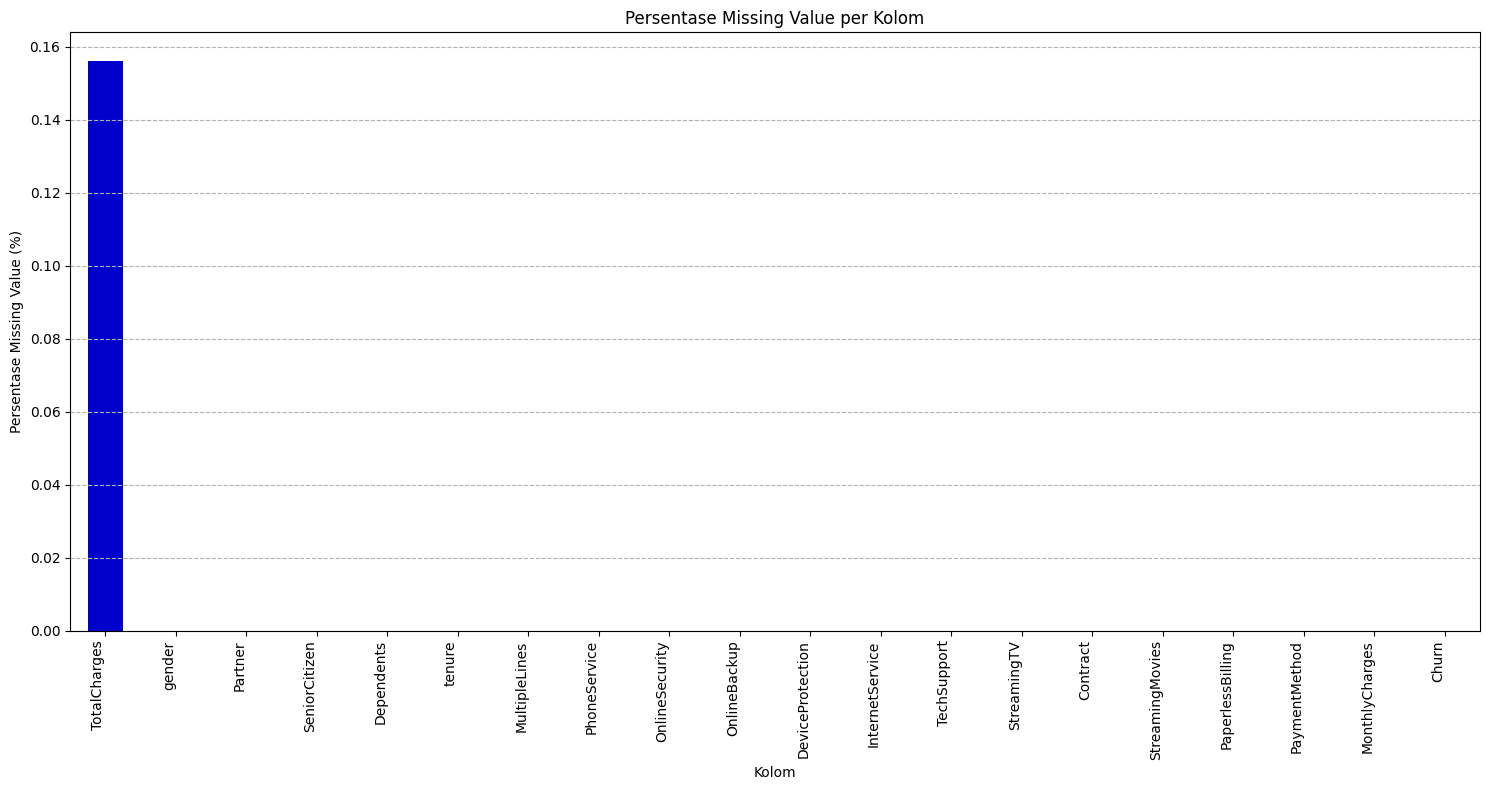

In [46]:
# Mengurutkan missing value tiap kolom
missing_val_to_plot = missing_val.sort_values(ascending=False)

plt.figure(figsize=(15, 8))
missing_val_to_plot.plot(kind='bar', color='mediumblue')
plt.title('Persentase Missing Value per Kolom')
plt.xlabel('Kolom')
plt.ylabel('Persentase Missing Value (%)')
plt.xticks(rotation=90, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

## Distribusi variabel target (*Churn)*

Churn
No     5174
Yes    1869
Name: count, dtype: int64


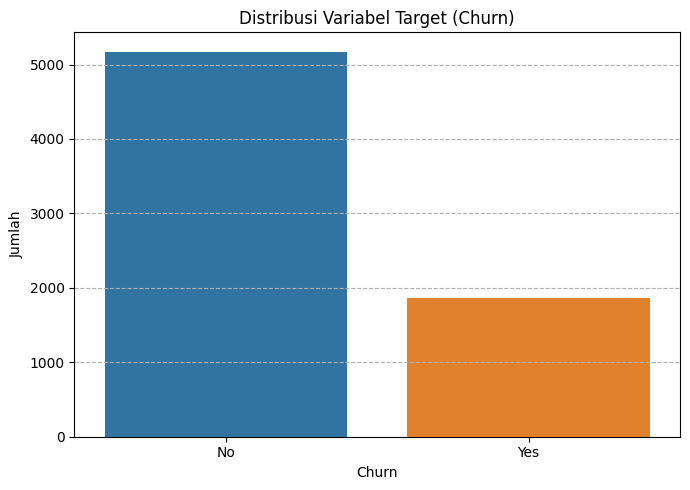

In [47]:
# Hitung distribusi variabel target
target_distribution = df['Churn'].value_counts()

# Jumlah data
print(target_distribution)

# Visualisasikan hasil distribusi
plt.figure(figsize=(7, 5))
sns.barplot(x=target_distribution.index, y=target_distribution.values, hue=target_distribution.index, legend=False)
plt.title('Distribusi Variabel Target (Churn)')
plt.xlabel('Churn')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


Hasil analisis distribusi variabel target 'Churn' menunjukkan adanya ketidakseimbangan data:

*   **Pelanggan Tidak Churn (No):** Terdapat 5174 pelanggan.
*   **Pelanggan Churn (Yes):** Terdapat 1869 pelanggan.



## Analisis Korelasi antar Fitur Numerik

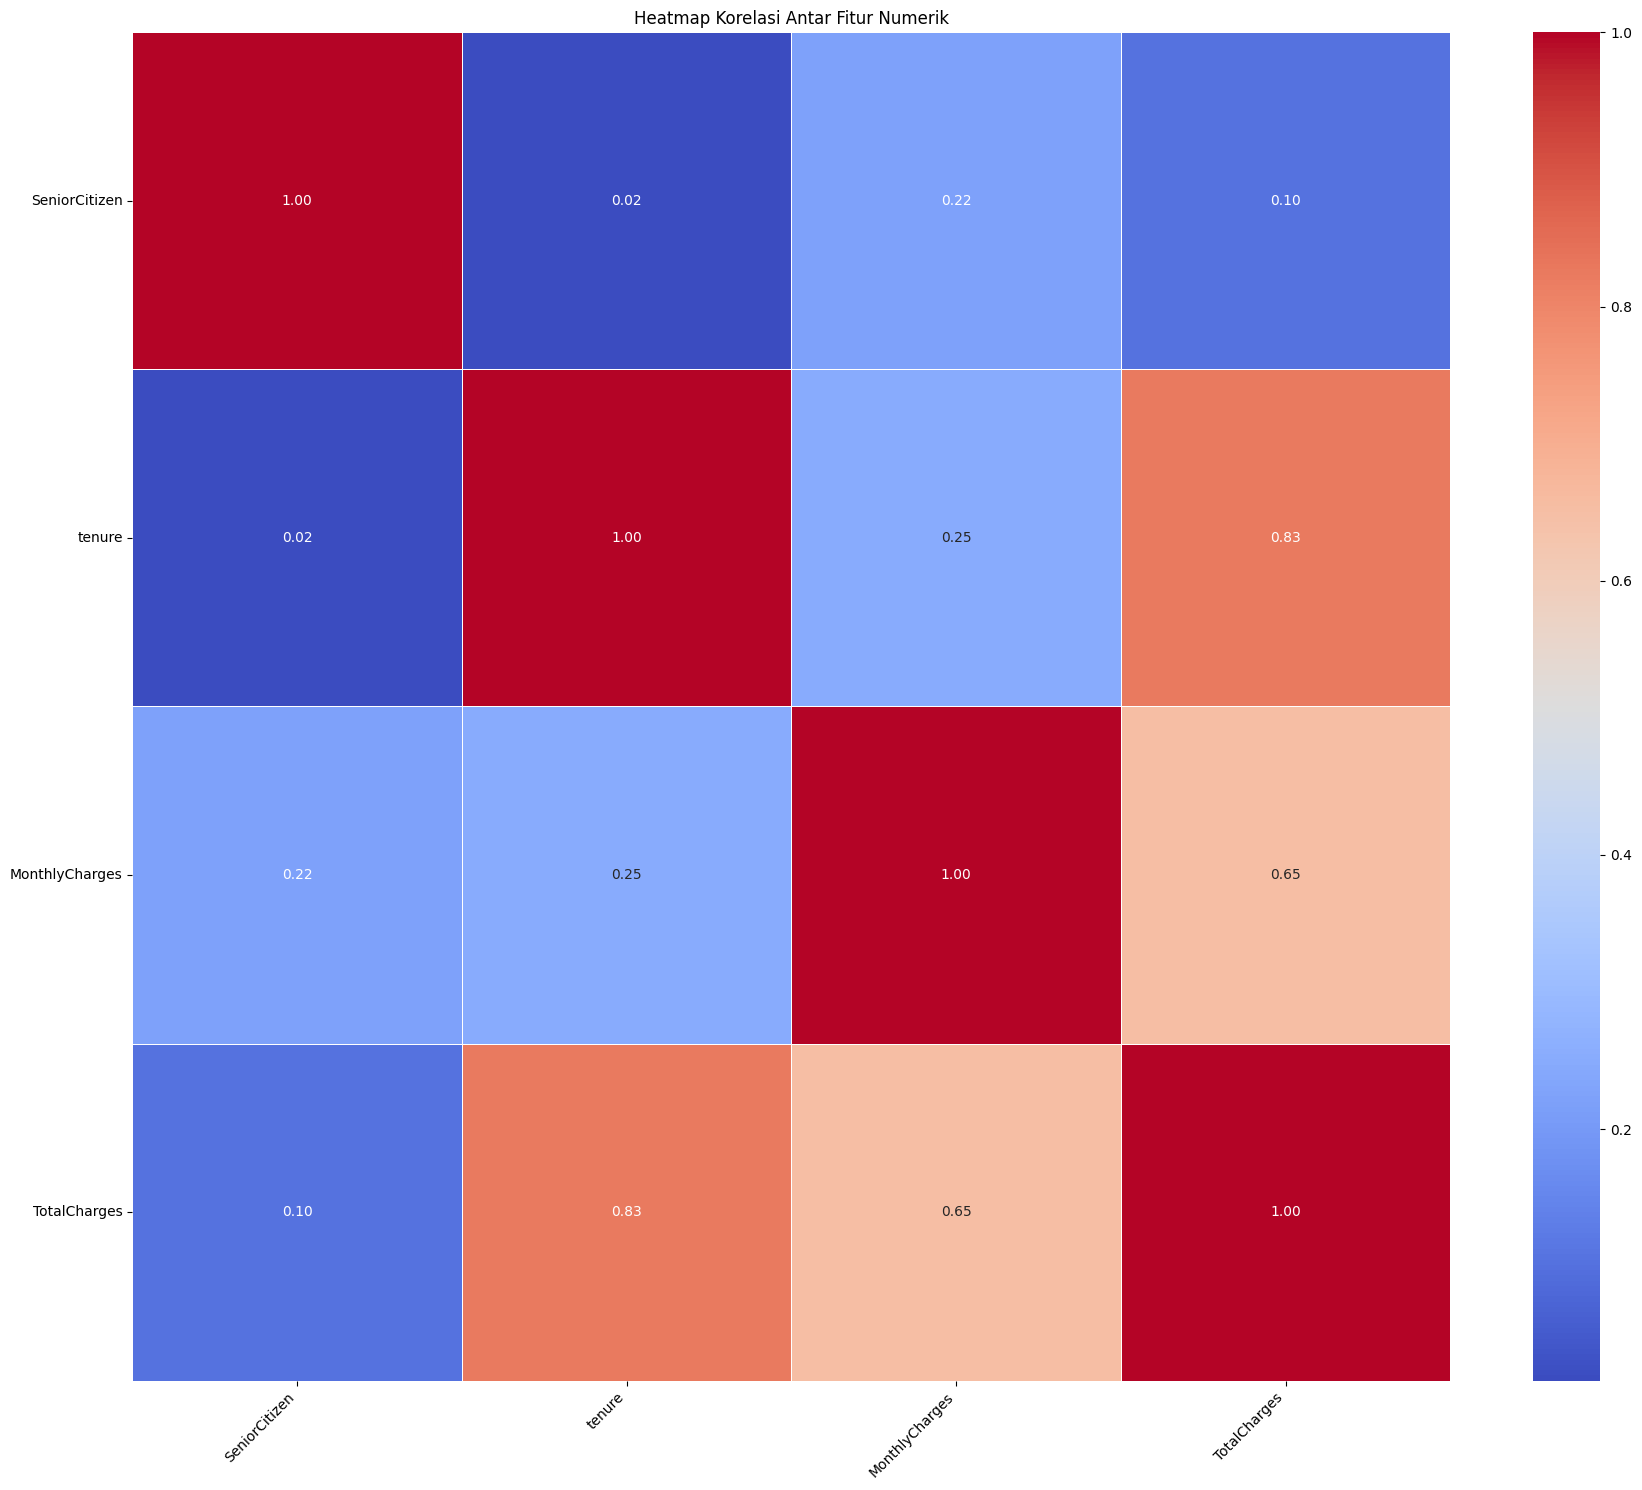

In [48]:
# Menampilkan kolom numerikal
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Menghitung matriks korelasi
correlation_matrix = numerical_df.corr()

# Membuat heatmap
plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap Korelasi Antar Fitur Numerik')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# **2. Direct Modeling**

## Menetapkan variabel x dan y

In [49]:
# Hanya menggunakan fitur numerik
X_direct = df.select_dtypes(include=['number']).fillna(0) # Mengisi NaN agar tidak error
y_direct = df['Churn'].map({'Yes': 1, 'No': 0}) # Encoding sederhana

## Train test split

In [50]:
X_train_dir, X_test_dir, y_train_dir, y_test_dir = train_test_split(X_direct, y_direct, test_size=0.2, random_state=42)

## Direct Modelling

=== Hasil Evaluasi Direct Modeling ===

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1036
           1       0.70      0.47      0.56       373

    accuracy                           0.81      1409
   macro avg       0.76      0.70      0.72      1409
weighted avg       0.79      0.81      0.79      1409



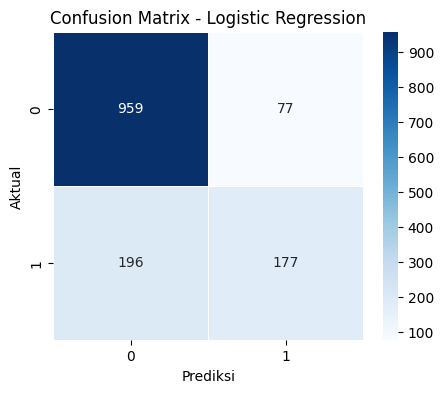

--------------------------------------------------

Model: Random Forest
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      1036
           1       0.57      0.47      0.51       373

    accuracy                           0.77      1409
   macro avg       0.69      0.67      0.68      1409
weighted avg       0.75      0.77      0.76      1409



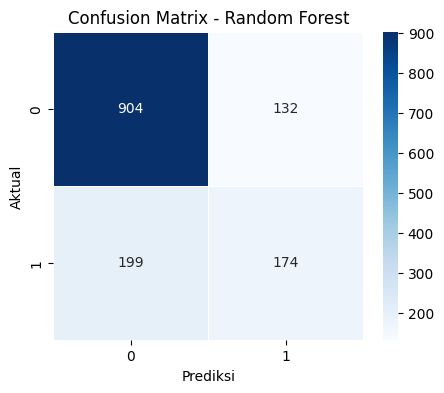

--------------------------------------------------

Model: Voting Classifier
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1036
           1       0.67      0.47      0.55       373

    accuracy                           0.80      1409
   macro avg       0.75      0.69      0.71      1409
weighted avg       0.79      0.80      0.79      1409



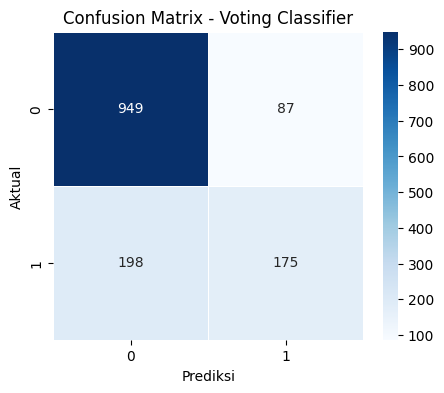

--------------------------------------------------


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.81,0.70,0.47,0.56
1,Random Forest,0.77,0.57,0.47,0.51
2,Voting Classifier,0.80,0.67,0.47,0.55


In [51]:
# Model Konvensional: Logistic Regression
model_lr = LogisticRegression(random_state=42, max_iter=1000)
# Model Ensemble Bagging: Random Forest
model_rf = RandomForestClassifier(random_state=42)
# Model Ensemble Voting: Kombinasi LR, KNN, dan RF
model_knn = KNeighborsClassifier()
model_voting = VotingClassifier(
    estimators=[('lr', model_lr), ('rf', model_rf), ('knn', model_knn)],
    voting='soft'
)

models = {
    'Logistic Regression': model_lr,
    'Random Forest': model_rf,
    'Voting Classifier': model_voting
}

# 4. Training dan Evaluasi
print("=== Hasil Evaluasi Direct Modeling ===")
results_direct = []

for name, model in models.items():
    # Training
    model.fit(X_train_dir, y_train_dir)
    y_pred = model.predict(X_test_dir)

    # Hitung Metrik
    acc = accuracy_score(y_test_dir, y_pred)
    prec = precision_score(y_test_dir, y_pred)
    rec = recall_score(y_test_dir, y_pred)
    f1 = f1_score(y_test_dir, y_pred)

    results_direct.append({'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1})

    print(f"\nModel: {name}")
    print(classification_report(y_test_dir, y_pred))

    cm = confusion_matrix(y_test_dir, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Aktual')
    plt.xlabel('Prediksi')
    plt.show()
    print("-" * 50)

df_results = pd.DataFrame(results_direct)

display(df_results.style.format("{:.2f}", subset=['Accuracy', 'Precision', 'Recall', 'F1-Score']))

# **3. Modeling dengan Preprocessing**

## Handling Missing Value

In [52]:
df.isnull().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


In [53]:
df.dropna(subset=['TotalCharges'], inplace=True)
print("Missing values after handling:")
print(df.isnull().sum())

Missing values after handling:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


## Handling Duplicate

In [54]:
duplicate_rows = df.duplicated().sum()
print(f"Jumlah data duplikat: {duplicate_rows}")

Jumlah data duplikat: 22


In [55]:
df.drop_duplicates(inplace=True)
duplicate_rows_after_handling = df.duplicated().sum()
print(f"Jumlah data duplikat setelah penghapusan: {duplicate_rows_after_handling}")

Jumlah data duplikat setelah penghapusan: 0


## Handling Outliers

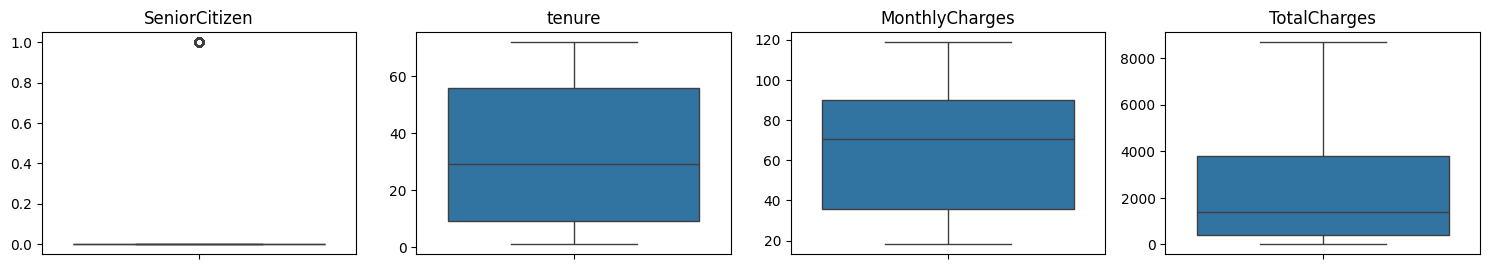

In [56]:
# Mengecek outliers setiap kolom numerik
numerik = df.select_dtypes(include=['float64', 'int64'])

# Buat box plot untuk setiap kolom numerik
plt.figure(figsize=(15, 10))
for i, kolom in enumerate(numerik, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=df[kolom])
    plt.title(kolom)
    plt.ylabel('')
plt.tight_layout()
plt.show()

SeniorCitizen tidak bisa dibilang memiliki outliers karena kolom tersebut hanya merepresentasikan kategori (tidak senior atau senior) dan bukan data numerik kontinu. Dikarenakan tidak ada outliers maka tidak perlu di lakukan handling.

## Label Encoding

In [57]:
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])

# Identify categorical columns (excluding target)
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if 'Churn' in categorical_cols:
    categorical_cols.remove('Churn')

# One-Hot Encode categorical features
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [58]:
df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7010 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7010 non-null   int64  
 1   tenure                                 7010 non-null   int64  
 2   MonthlyCharges                         7010 non-null   float64
 3   TotalCharges                           7010 non-null   float64
 4   Churn                                  7010 non-null   int64  
 5   gender_Male                            7010 non-null   bool   
 6   Partner_Yes                            7010 non-null   bool   
 7   Dependents_Yes                         7010 non-null   bool   
 8   PhoneService_Yes                       7010 non-null   bool   
 9   MultipleLines_No phone service         7010 non-null   bool   
 10  MultipleLines_Yes                      7010 non-null   bool   
 11  InternetS

## Train Test Split

In [60]:
X_prep = df.drop(['Churn'], axis=1)
y_prep = df['Churn']

X_train_prep, X_test_prep, y_train_prep, y_test_prep = train_test_split(X_prep, y_prep, test_size=0.2, random_state=42)

## Scaling

In [61]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

scaler = StandardScaler()

X_train_prep[numerical_cols] = scaler.fit_transform(X_train_prep[numerical_cols])
X_test_prep[numerical_cols] = scaler.transform(X_test_prep[numerical_cols])

## Modeling

=== Hasil Evaluasi Modeling Setelah Preprocessing ===

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1081
           1       0.62      0.58      0.60       321

    accuracy                           0.82      1402
   macro avg       0.75      0.74      0.74      1402
weighted avg       0.82      0.82      0.82      1402



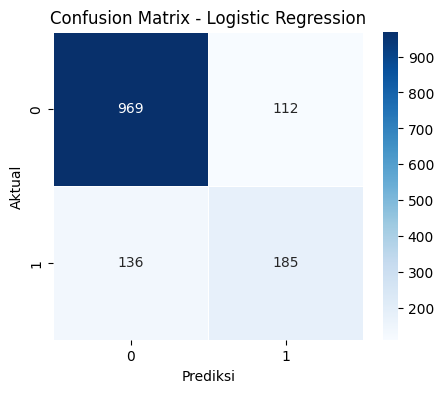

--------------------------------------------------

Model: Random Forest
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1081
           1       0.58      0.51      0.54       321

    accuracy                           0.80      1402
   macro avg       0.72      0.70      0.71      1402
weighted avg       0.79      0.80      0.80      1402



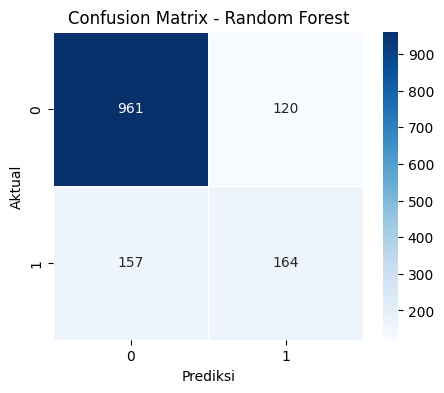

--------------------------------------------------

Model: Voting Classifier
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1081
           1       0.57      0.54      0.55       321

    accuracy                           0.80      1402
   macro avg       0.72      0.71      0.71      1402
weighted avg       0.80      0.80      0.80      1402



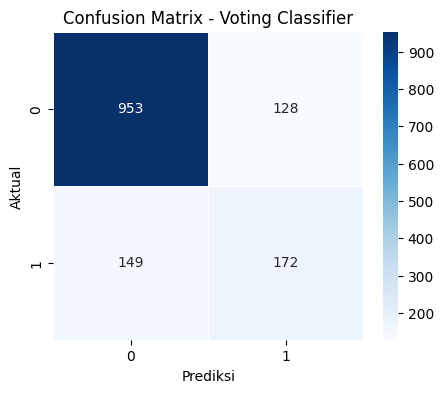

--------------------------------------------------


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.82,0.62,0.58,0.60
1,Random Forest,0.80,0.58,0.51,0.54
2,Voting Classifier,0.80,0.57,0.54,0.55


In [62]:
# Model Konvensional: Logistic Regression
model_lr = LogisticRegression(random_state=42, max_iter=1000)
# Model Ensemble Bagging: Random Forest
model_rf = RandomForestClassifier(random_state=42)
# Model Ensemble Voting: Kombinasi LR, KNN, dan RF
model_knn = KNeighborsClassifier()
model_voting = VotingClassifier(
    estimators=[('lr', model_lr), ('rf', model_rf), ('knn', model_knn)],
    voting='soft'
)

models = {
    'Logistic Regression': model_lr,
    'Random Forest': model_rf,
    'Voting Classifier': model_voting
}

# 4. Training dan Evaluasi
print("=== Hasil Evaluasi Modeling Setelah Preprocessing ===")
results_prep = []

for name, model in models.items():
    # Training
    model.fit(X_train_prep, y_train_prep)
    y_pred_prep = model.predict(X_test_prep)

    # Hitung Metrik
    acc = accuracy_score(y_test_prep, y_pred_prep)
    prec = precision_score(y_test_prep, y_pred_prep)
    rec = recall_score(y_test_prep, y_pred_prep)
    f1 = f1_score(y_test_prep, y_pred_prep)

    results_prep.append({'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1})

    print(f"\nModel: {name}")
    print(classification_report(y_test_prep, y_pred_prep))

    cm = confusion_matrix(y_test_prep, y_pred_prep)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Aktual')
    plt.xlabel('Prediksi')
    plt.show()
    print("-" * 50)

df_results = pd.DataFrame(results_prep)

display(df_results.style.format("{:.2f}", subset=['Accuracy', 'Precision', 'Recall', 'F1-Score']))

# 4. Hyperparameter Tuning

## Tuning Logistic Regression

Mencari parameter terbaik
Fitting 5 folds for each of 24 candidates, totalling 120 fits

--- Hasil Tuning ---
Parameter Terbaik: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Skor Terbaik (F1-Score): 0.6029

--- Evaluasi pada Data Test ---
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1081
           1       0.63      0.59      0.61       321

    accuracy                           0.83      1402
   macro avg       0.75      0.74      0.75      1402
weighted avg       0.82      0.83      0.82      1402



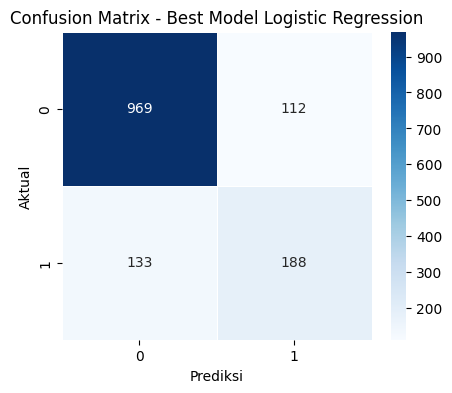

In [63]:
# Menentukan Parameter
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(estimator=log_reg,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1',
                           n_jobs=-1,
                           verbose=2)

# Latih Grid Search dengan data TRAIN
print("Mencari parameter terbaik")
grid_search.fit(X_train_prep, y_train_prep)

print("\n--- Hasil Tuning ---")
print(f"Parameter Terbaik: {grid_search.best_params_}")
print(f"Skor Terbaik (F1-Score): {grid_search.best_score_:.4f}")

# Ambil model terbaik
best_lr_model = grid_search.best_estimator_

# Evaluasi ke data Test (Validasi akhir)
from sklearn.metrics import classification_report
y_pred_tun = best_lr_model.predict(X_test_prep)

print("\n--- Evaluasi pada Data Test ---")
print(classification_report(y_test_prep, y_pred_tun))

cm = confusion_matrix(y_test_prep, y_pred_tun)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title(f'Confusion Matrix - Best Model Logistic Regression')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()


## Tuning Random Forest

Mulai Tuning Random Forest
Fitting 5 folds for each of 108 candidates, totalling 540 fits

--- Hasil Tuning Random Forest ---
Parameter Terbaik: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Skor F1 Terbaik: 0.5907

--- Evaluasi pada Data Test ---
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1081
           1       0.60      0.53      0.56       321

    accuracy                           0.81      1402
   macro avg       0.73      0.71      0.72      1402
weighted avg       0.80      0.81      0.81      1402



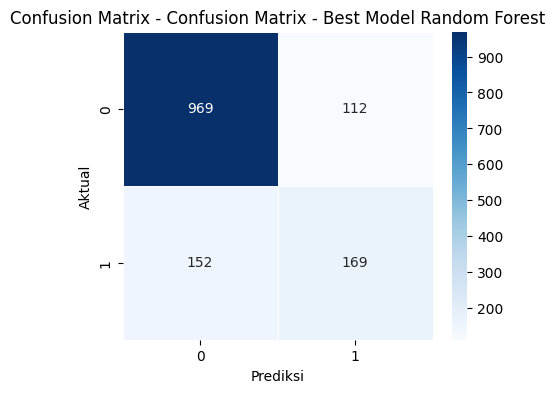

In [64]:
# 1. Definisi Model Dasar
rf = RandomForestClassifier(random_state=42)

# 2. Definisi Parameter Grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 3. Jalankan Grid Search
print("Mulai Tuning Random Forest")
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=param_grid_rf,
                       cv=5,
                       scoring='f1',
                       n_jobs=-1,
                       verbose=1)

grid_rf.fit(X_train_prep, y_train_prep)

# 4. Hasil Terbaik
print("\n--- Hasil Tuning Random Forest ---")
print(f"Parameter Terbaik: {grid_rf.best_params_}")
print(f"Skor F1 Terbaik: {grid_rf.best_score_:.4f}")

# Simpan model RF terbaik ke variabel
best_rf_model = grid_rf.best_estimator_

# Evaluasi ke data Test (Validasi akhir)
from sklearn.metrics import classification_report
y_pred_tun = best_rf_model.predict(X_test_prep)

print("\n--- Evaluasi pada Data Test ---")
print(classification_report(y_test_prep, y_pred_tun))

cm = confusion_matrix(y_test_prep, y_pred_tun)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title(f'Confusion Matrix - Confusion Matrix - Best Model Random Forest')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()

## Tuning KNN

In [65]:
# 1. Definisi Model Dasar
knn = KNeighborsClassifier()

# 2. Definisi Parameter Grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# 3. Jalankan Grid Search
print("Mulai Tuning KNN...")
grid_knn = GridSearchCV(estimator=knn,
                        param_grid=param_grid_knn,
                        cv=5,
                        scoring='f1',
                        n_jobs=-1,
                        verbose=1)

grid_knn.fit(X_train_prep, y_train_prep)

# 4. Hasil Terbaik
print("\n--- Hasil Tuning KNN ---")
print(f"Parameter Terbaik: {grid_knn.best_params_}")
print(f"Skor F1 Terbaik: {grid_knn.best_score_:.4f}")

# Simpan model KNN terbaik
best_knn_model = grid_knn.best_estimator_

Mulai Tuning KNN...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

--- Hasil Tuning KNN ---
Parameter Terbaik: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}
Skor F1 Terbaik: 0.6026


## Tuning Voting Classifier


Mulai Tuning Voting Classifier (LR + RF + KNN)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

--- Hasil Tuning Voting ---
Bobot Terbaik: {'weights': [1, 2, 2]}
Skor F1 Terbaik: 0.6070

--- Evaluasi pada Data Test ---
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1081
           1       0.61      0.56      0.58       321

    accuracy                           0.82      1402
   macro avg       0.74      0.73      0.73      1402
weighted avg       0.81      0.82      0.81      1402



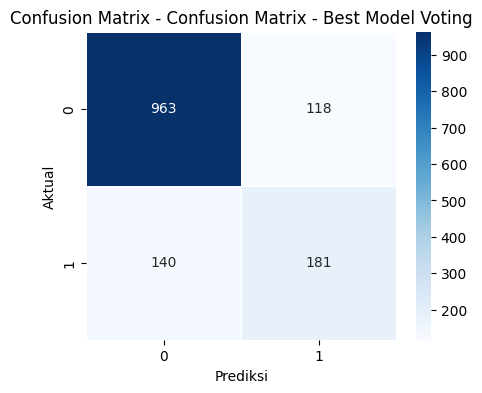

In [66]:
# Definisi Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', best_lr_model),
        ('rf', best_rf_model ),
        ('knn', best_knn_model)
    ],
    voting='soft'
)

# Definisi Grid untuk Weights
param_grid_voting = {
    'weights': [
        [1, 1, 1],
        [1, 2, 1],
        [1, 1, 2],
        [2, 1, 1],
        [1, 2, 2]
    ]
}

# Jalankan Grid Search
print("\nMulai Tuning Voting Classifier (LR + RF + KNN)")
grid_voting = GridSearchCV(estimator=voting_clf,
                           param_grid=param_grid_voting,
                           cv=5,
                           scoring='f1',
                           n_jobs=-1,
                           verbose=1)

grid_voting.fit(X_train_prep, y_train_prep)

# Hasil Terbaik
print("\n--- Hasil Tuning Voting ---")
print(f"Bobot Terbaik: {grid_voting.best_params_}")
print(f"Skor F1 Terbaik: {grid_voting.best_score_:.4f}")

# Simpan model Voting terbaik
best_voting_model = grid_voting.best_estimator_

# Evaluasi ke data Test (Validasi akhir)
from sklearn.metrics import classification_report
y_pred_tun = best_voting_model.predict(X_test_prep)

print("\n--- Evaluasi pada Data Test ---")
print(classification_report(y_test_prep, y_pred_tun))

cm = confusion_matrix(y_test_prep, y_pred_tun)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title(f'Confusion Matrix - Confusion Matrix - Best Model Voting')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()


In [67]:
models_comparison = {
    'Logistic Regression (Tuned)': best_lr_model,
    'Random Forest (Tuned)': best_rf_model,
    'Voting Classifier (Tuned)': best_voting_model
}

print("=== Perbandingan Hasil Hyperparameter Tuning ===")
results_tuning = []

for name, model in models_comparison.items():

    model.fit(X_train_prep, y_train_prep)

    # Prediksi
    y_pred = model.predict(X_test_prep)

    # Hitung Metrik
    acc = accuracy_score(y_test_prep, y_pred)
    prec = precision_score(y_test_prep, y_pred)
    rec = recall_score(y_test_prep, y_pred)
    f1 = f1_score(y_test_prep, y_pred)

    # Simpan ke list
    results_tuning.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

df_results = pd.DataFrame(results_tuning)
pd.options.display.float_format = '{:.2f}'.format
display(df_results)

=== Perbandingan Hasil Hyperparameter Tuning ===


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression (Tuned),0.83,0.63,0.59,0.61
1,Random Forest (Tuned),0.81,0.60,0.53,0.56
2,Voting Classifier (Tuned),0.82,0.61,0.56,0.58


# 5. Analisis Perbandingan Model


Perbandingan performa model setelah melalui tiga tahapan eksperimen: (1) Direct Modeling, (2) Setelah Preprocessing, dan (3) Setelah Hyperparameter Tuning.

## 1. Tahap 1: Direct Modeling

Pada tahap ini, data mentah langsung dimasukkan ke dalam model tanpa preprocessing data.

| Model | Accuracy | Precision (Churn) | Recall (Churn) | F1-Score (Churn) |
| --- | --- | --- | --- | --- |
| **Logistic Regression** | **0.81** | **0.70** | 0.47 | **0.56** |
| **Random Forest** | 0.77 | 0.57 | 0.47 | 0.51 |
| **Voting Classifier** | 0.80 | 0.67 | 0.47 | 0.55 |

**Analisis:**

* Meskipun Accuracy terlihat cukup tinggi (0.81), model gagal menangkap pola Churn dengan baik. Hal ini terlihat dari nilai Recall yang rendah (0.47) pada semua model. Model cenderung bias ke kelas mayoritas (Non-Churn).

## 2. Tahap 2: Preprocessing

Pada tahap ini, dilakukan pembersihan data, penanganan *missing values* dan duplikasi data, *encoding*, dan *scaling*.

| Model | Accuracy | Precision (Churn) | Recall (Churn) | F1-Score (Churn) |
| --- | --- | --- | --- | --- |
| **Logistic Regression** | **0.82** | **0.62** | **0.58** | **0.60** |
| **Random Forest** | 0.80 | 0.58 | 0.51 | 0.54 |
| **Voting Classifier** | 0.80 | 0.57 | 0.54 | 0.55 |

**Analisis:**

* Terjadi peningkatan signifikan pada Logistic Regression ( Terutama Recall naik dari 0.47 menjadi 0.58).
* Preprocessing terbukti membantu model membedakan pola antar kelas dengan lebih baik. Logistic Regression menjadi model yang paling diuntungkan dari proses preprocessing ini.

## 3. Tahap 3: Hyperparameter Tuning

Tahap terakhir adalah mengoptimalkan parameter model menggunakan GridSearchCV.

| Model | Accuracy | Precision (Churn) | Recall (Churn) | F1-Score (Churn) |
| --- | --- | --- | --- | --- |
| **Logistic Regression (Tuned)** | **0.83** | **0.63** | **0.59** | **0.61** |
| **Random Forest (Tuned)** | 0.81 | 0.60 | 0.53 | 0.56 |  |
| **Voting Classifier (Tuned)** | 0.82 | 0.61 | 0.56 | 0.58 |  |

**Analisis:**

1. Logistic Regression (Tuned) sebagai model terbaik dengan Akurasi 0.83, F1-Score 0.61 dan Recall 0.59.
2. Model lain juga mengalami beberapa peningkatan.

## Kesimpulan
Dari eksperimen di atas, didapatkan keismpulan bahwa metode-metode seperti Preprocessing Data dan Hyperparameter Tuning sangat berpengaruh pada kualitas model.

**Logistic Regression (Tuned)** akan dipilih sebagai Best Model yang memiliki keseimbangan terbaik antara Precision dan Recall serta F1-Score tertinggi. Sehingga model ini akan dipilih menjadi model untuk di-deploy pada aplikasi prediksi Churn.

# 6. Export Model dan Scaler

In [68]:
import joblib

model_artifacts = {
    'model': best_lr_model,          # Model LR Tuned
    'scaler': scaler,                # Scaler
    'features': X_train_prep.columns.tolist() # Daftar nama kolom final setelah di one hot encoding
}

joblib.dump(model_artifacts, 'churn_prediction_bestmodel.pkl')
print("Model, Scaler, dan Fitur berhasil disimpan ke 'churn_prediction_bestmodel.pkl'")

Model, Scaler, dan Fitur berhasil disimpan ke 'churn_prediction_bestmodel.pkl'


In [69]:
from google.colab import files
files.download('churn_prediction_bestmodel.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>